In [1]:
import sys
sys.path.append('/home/decker/lab433')

from synoptic import get_gfs1deg

from datetime import datetime, timedelta

import numpy as np

import xarray as xr
from metpy.units import units
from metpy.plots import ContourPlot, FilledContourPlot, BarbPlot, MapPanel, PanelContainer
import metpy.calc as mpcalc

In [2]:
init_time = datetime(2024, 9, 25, 6)
plot_time = init_time + timedelta(hours=30)
gfs = get_gfs1deg(init_time, plot_time)


In [13]:
ht850 = gfs['Geopotential_height_isobaric'].metpy.sel(vertical=850 * units.hPa)[:,10:81,180:310]
ht300 = gfs['Geopotential_height_isobaric'].metpy.sel(vertical=300 * units.hPa)[:,10:81,180:310]

ht500 = gfs['Geopotential_height_isobaric'].metpy.sel(vertical=500 * units.hPa)[:,10:81,180:310]

u300 = gfs['u-component_of_wind_isobaric'].metpy.sel(vertical=300 * units.hPa)[:,10:81,180:310]
v300 = gfs['v-component_of_wind_isobaric'].metpy.sel(vertical=300 * units.hPa)[:,10:81,180:310]

geoV0u, geoV0v = mpcalc.geostrophic_wind(ht850)

geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')

geo850 = xr.merge([geoV0u,geoV0v])

geoVu, geoVv = mpcalc.geostrophic_wind(ht300)

geoVu = geoVu.rename('u')
geoVv = geoVv.rename('v')

geo300 = xr.merge([geoVu,geoVv])

thermal = geo300 - geo850

In [4]:
t2 = init_time + timedelta(hours=36)
t3 = init_time + timedelta(hours=24)

slp1 = get_gfs1deg(init_time, t2)
slp2 = get_gfs1deg(init_time, t3)

mslp1 = slp1['MSLP_Eta_model_reduction_msl']
mslp2 = slp2['MSLP_Eta_model_reduction_msl']

isall = mslp1.squeeze('time1') - mslp2.squeeze('time1')

In [5]:
d1 = mpcalc.first_derivative(geoV0u, axis = 'x')
d2 = mpcalc.first_derivative(geoV0u, axis = 'y')

term1 = d1*thermal['u']
term2 = d2*thermal['v']
b = term1+term2

dv0_x = mpcalc.first_derivative(geoV0v, axis = 'x')
dv0_y = mpcalc.first_derivative(geoV0v, axis = 'y')

fterm = dv0_x*thermal['u']
sterm = dv0_y*thermal['v']
c = fterm + sterm

i_f = b.rename('horiz')
j_f = c.rename('vert')

shearing = xr.merge([j_f, i_f])

In [6]:
termfinal = xr.merge([j_f, i_f])
coriolis = mpcalc.coriolis_parameter(termfinal['latitude'])
termfinal2 = termfinal/(coriolis)

final = mpcalc.divergence(termfinal2['horiz'], termfinal2['vert'])


In [7]:
smoothing = 8
finalsmooth = mpcalc.smooth_gaussian(final, smoothing)

Panel 1

In [8]:
thermalwind = BarbPlot()
thermalwind.data = thermal
thermalwind.time = plot_time
thermalwind.field = ['u', 'v']
thermalwind.color = 'cyan'
thermalwind.skip = (4,3)
thermalwind.plot_units = 'knot'

V0 = BarbPlot()
V0.data = geo850
V0.time = plot_time
V0.field  = ['u', 'v']
V0.skip = (4,1)
V0.plot_units = 'knot'

panel1 = MapPanel()
panel1.layout = (2,2,1)
panel1.area = [-140,-100,40,65]
panel1.projection = 'mer'
panel1.layers = ['states', 'coastline', 'borders']
panel1.title = f'{plot_time}'
panel1.plots = [thermalwind,V0]


Panel 2

In [9]:
shear = BarbPlot()
shear.data = shearing
shear.time = plot_time
shear.scale = 3e4
shear.field = ['horiz', 'vert']
shear.skip = (4,3)

panel2 = panel1.copy()
panel2.layout = (2, 2, 2)
panel2.title = f'Shearing Surface Wind (kt) {plot_time}'
panel2.plots = [shear]


Panel 3

In [10]:
div = ContourPlot()
div.data = finalsmooth
div.time = plot_time
div.contours = range(1,35,2)
div.scale = 1e5
div.linecolor = 'cyan'
div.linestyle = 'solid'
div.clabels = True
div.plot_units = '1/s'

div2 = ContourPlot()
div2.data = finalsmooth
div2.time = plot_time
div2.contours = range(-35,-1,2)
div2.scale = 1e5
div2.linecolor = 'lime'
div2.linestyle = 'dashed'
div2.clabels = True
div2.plot_units = '1/s'

panel3 = MapPanel()
panel3.area = [-140,-100,40,65]
panel3.projection = 'mer'
panel3.layout = (2, 2, 3)
panel3.layers = ['states', 'coastline', 'borders']
panel3.title = f'Change in Divergence w HeightAccording to Shearing over Surface Wind Term at {plot_time}'
panel3.plots = [div, div2]


Panel 4

In [11]:
i1 = ContourPlot()
i1.data = isall
i1.contours = range(0, 1000, 3)
i1.scale = 1e5
i1.linecolor = 'red'
i1.linestyle = 'solid'
i1.clabels = True
i1.plot_units = 'hPa'

i2 = ContourPlot()
i2.data = isall
i2.contours = range(-1000, 0, 3)
i2.scale = 1e5
i2.linecolor = 'darkorange'
i2.linestyle = 'dashed'
i2.clabels = True
i2.plot_units = 'hPa'

panel4 = MapPanel()
panel4.layout = (2, 2, 4)
panel4.area = [-140,-100,40,65]
panel4.projection = 'mer'
panel4.layers = ['states', 'coastline', 'borders']
panel4.title = f'Isallobars at {plot_time}'
panel4.plots = [i1, i2]

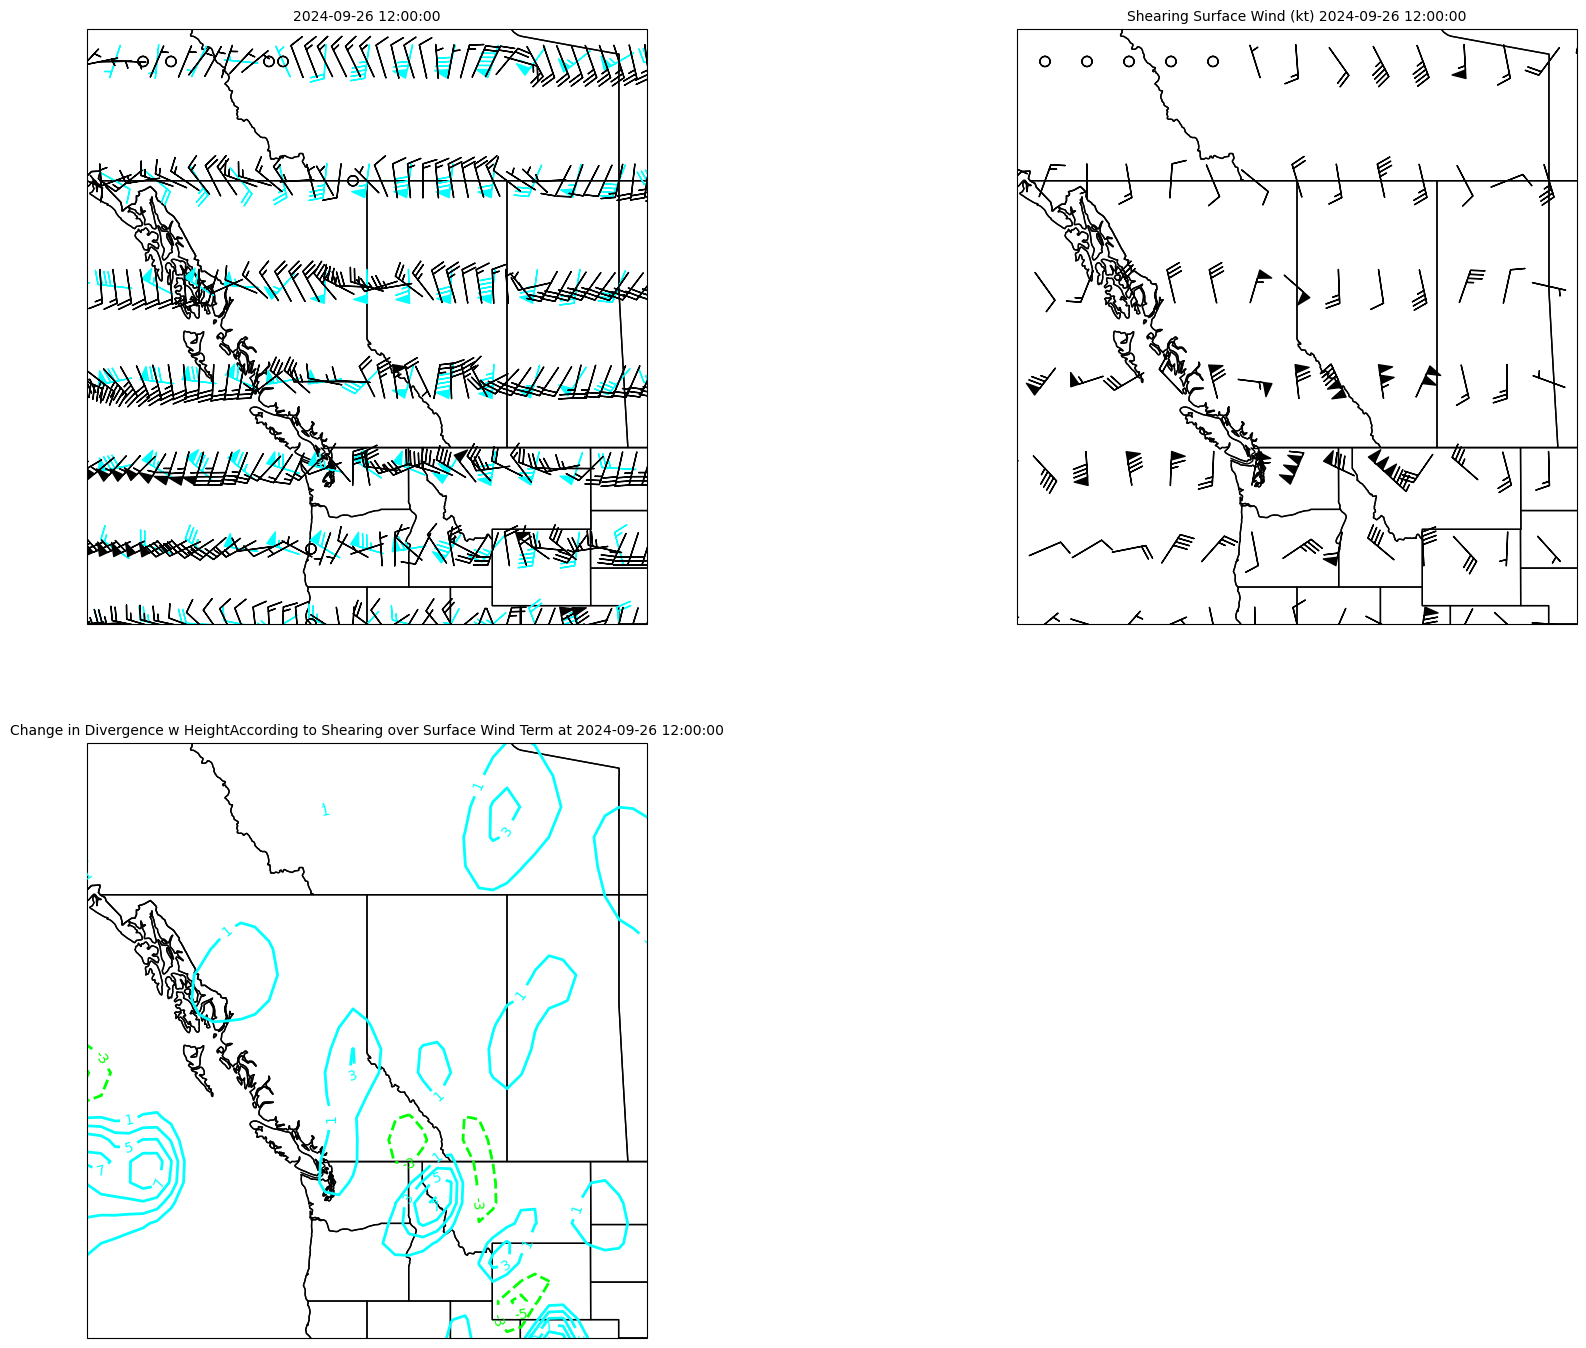

In [12]:
pc = PanelContainer()
pc.size = (22,17)
pc.panels = [panel1,panel2,panel3]
pc.show()